In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.models as torch_models

import onnx
import onnxruntime

import io
import json
import base64
import random
from PIL import Image

In [2]:
# dataset

cat_path = '/home/wyundi/Server/Courses/CS546/project/data/cat/cat.json'
with open(cat_path, 'r') as f:
    cat_json = json.load(f)
    
print(type(cat_json))
for key in cat_json.keys():
    print(key, ': ', len(cat_json[key]))

<class 'dict'>
image_base64_string :  6000
label :  6000


## Read Data

In [3]:
cat_df = pd.DataFrame.from_dict(cat_json)
print(cat_df.head())

print(cat_df.size)

                                 image_base64_string  label
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      1
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      1
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      0
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      1
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      0
12000


In [4]:
# print(cat_df.iloc[0].at['image_base64_string'])

In [5]:
# for i in range(cat_df.shape[0]):
#     img = base64.b64decode(cat_df.iloc[i].at['image_base64_string'])
#     img = Image.open(io.BytesIO(img))
#     img_np = np.array(img)
#     print(img_np.shape) 

1


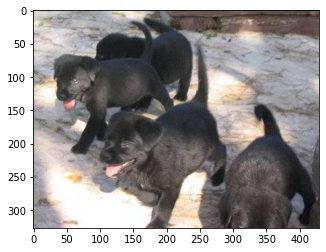

In [6]:
img = base64.b64decode(cat_df.iloc[3].at['image_base64_string'])
img = Image.open(io.BytesIO(img))
plt.imshow(img)

label = cat_df.iloc[3].at['label']
print(label)

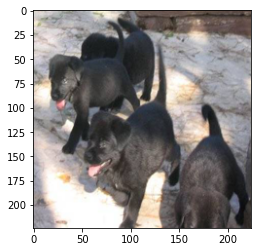

In [7]:
img = img.resize((224, 224))
plt.imshow(img)

In [8]:
label = cat_df.iloc[0].at['label']
print(label)
print(type(label))

1
<class 'numpy.int64'>


In [9]:
img_np = np.array(img)
print(img_np.shape)

img_tensor = torch.tensor(img_np.transpose(2, 0, 1), dtype=torch.float32)
print(img_tensor.size())

(224, 224, 3)
torch.Size([3, 224, 224])


## Model

In [10]:
# device

def set_device(net, device='GPU'):
    if device == 'GPU':
        torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        torch_device = torch.device("cpu")

    if torch.cuda.device_count() > 1:
        model = nn.DataRarallel(model)

    net = net.to(torch_device)
    return net, torch_device

In [11]:
class dataset(Dataset):
    def __init__(self, df):
        
        self.dataset_df = df

        self.img_shape = (256, 256)
        self.crop_shape = (224, 224)
        
        self.__transforms = torch.nn.Sequential(
            T.RandomCrop(self.crop_shape),
            T.RandomHorizontalFlip(p=0.3),
        )
        
        self.data_list = []
        self.label_list = []
        
        for i in range(df.shape[0]):
            self.label_list.append(df.iloc[i].at['label'])
            self.data_list.append(df.iloc[i].at['image_base64_string'])
            
        self.data = list(zip(self.data_list, self.label_list))
        
    def __getitem__(self, index):
        
        self.__img_string, self.__img_label = self.data[index]
        
        self.__img = base64.b64decode(self.__img_string)
        self.__img = Image.open(io.BytesIO(self.__img))
        
        self.__img = self.__img.resize(self.img_shape)
        self.__img = self.__transforms(self.__img)
        
        self.__img_np = np.array(self.__img) / 255.0
        
        self.__img_tensor = torch.tensor(self.__img_np.transpose(2, 0, 1), dtype=torch.float32)
        self.__img_label = torch.tensor(self.__img_label, dtype=torch.long)
        
        return (self.__img_tensor, self.__img_label)
    
    def __len__(self):
        return len(self.data)

    def get_name(self):
        return self.name_list
        

In [12]:
class Convnet(nn.Module):
    def __init__(self, num_classes=1000):
        super(Convnet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(start_dim=1, end_dim=3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




Net = Convnet(2)
input_shape = (16, 3, 224, 224)

print(Net)

print(summary(Net, input_shape))

Convnet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(s

In [13]:
# # helper function for classification

def calc_acc(out, labels):
    num = out.size(0)
    prediction = out.argmax(dim=1)
    return (prediction == labels).sum().item()/num

def evaluate(model, torch_device, loss_func, dataloader, method='classification'):
    loss = 0
    acc = 0

    loss_list = []
    acc_list = []
    
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(torch_device)
            labels = labels.to(torch_device)

            out = model(inputs)
            loss_list.append(loss_func(out, labels))

            if method == 'classification':
                acc_list.append(calc_acc(out, labels))

        loss = torch.mean(torch.tensor(loss_list))

    if method == 'classification':
        acc = torch.mean(torch.tensor(acc_list, dtype=torch.float32))
        return loss, acc
    elif method == 'regression':
        return loss


In [14]:
# Define a train function

def train_model(model, train_dataset, test_dataset, batch = 256, epochs=50,
                lr=0.005, class_weights = None, weight_decay = 0):

    # train_history
    train_history = {}
    train_history['train_loss'] = []
    train_history['train_acc'] = []

    train_history['test_loss'] = []
    train_history['test_acc'] = []

    # set device
    model, torch_device = set_device(model)
    
    if class_weights != None:
        class_weights = class_weights.to(torch_device)

    # Dataloader
    train_dl = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=batch, shuffle=True)
    
    # optimzer and loss_func
    optimzer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    loss_func = nn.CrossEntropyLoss(weight = class_weights)

    # train_process
    for epoch in range(epochs):
        
        for step, (inputs, labels) in enumerate(train_dl):
            
            inputs = inputs.to(torch_device)
            labels = labels.to(torch_device)

            out = model(inputs)
            loss = loss_func(out, labels)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            
            # output
            train_loss, train_acc = evaluate(model, torch_device, loss_func, train_dl)
            test_loss, test_acc = evaluate(model, torch_device, loss_func, test_dl)

            print(  'Epoch:', epoch+1, '/', epochs, ', '\
                    'train_loss: {loss:.5f}, '.format(loss = train_loss), \
                    'train_acc: {acc:.5f}, '.format(acc = train_acc), \
                    'test_loss: {loss:.5f}, '.format(loss = test_loss), \
                    'test_acc: {acc:.5f}'.format(acc = test_acc))

            train_history['train_loss'].append(train_loss)
            train_history['train_acc'].append(train_acc)

            train_history['test_loss'].append(test_loss)
            train_history['test_acc'].append(test_acc)
  
    return train_history

In [15]:
# split dataframe

split_rate = 0.85

df_train = cat_df.iloc[:int(cat_df.shape[0]*split_rate), :]
df_test = cat_df.iloc[int(cat_df.shape[0]*split_rate):, :]

In [16]:
train_dataset = dataset(df_train)
test_dataset = dataset(df_test)

batch = 64
epochs = 25
lr = 0.001

In [ ]:
"""
Train Model
"""

# load model
model = Convnet(2)
print(summary(model, (10, 3, 224, 224)))

# train
hist = train_model(model, train_dataset, test_dataset, batch, epochs, lr)

Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  --                        --
├─Sequential: 1-1                        [10, 9216]                --
│    └─Conv2d: 2-1                       [10, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [10, 64, 224, 224]        --
│    └─MaxPool2d: 2-3                    [10, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [10, 192, 112, 112]       110,784
│    └─ReLU: 2-5                         [10, 192, 112, 112]       --
│    └─MaxPool2d: 2-6                    [10, 192, 55, 55]         --
│    └─Conv2d: 2-7                       [10, 384, 55, 55]         663,936
│    └─ReLU: 2-8                         [10, 384, 55, 55]         --
│    └─MaxPool2d: 2-9                    [10, 384, 27, 27]         --
│    └─Conv2d: 2-10                      [10, 256, 27, 27]         884,992
│    └─ReLU: 2-11                        [10, 256, 27, 27]         